In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [15]:
%load_ext pycodestyle_magic
%flake8_on

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# I. Création des indicateurs RFM

In [16]:
# Importation

df_customers = pd.read_csv("olist_customers_dataset.csv")

# Supprimer des clients dupliqués

df_customers.drop_duplicates(subset="customer_unique_id",
                             inplace=True)
df_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [17]:
df_orders = pd.read_csv("olist_orders_dataset.csv")

In [18]:
# Combiner les clients avec les achats pour calculer Récence et Fréquence
df = pd.merge(df_customers,
              df_orders,
              left_on="customer_id",
              right_on="customer_id",
              how="right")
df.drop_duplicates(subset="customer_id",
                   inplace=True)

In [19]:
df_orders_payments = pd.read_csv("olist_order_payments_dataset.csv")

In [20]:
# Combiner les clients, les achats et les paiements
# pour calculer le Montant (MonetaryValue)
df = pd.merge(df, df_orders_payments, left_on="order_id",
              right_on="order_id", how="right")

In [21]:
# Transformer timestamps à datetime
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols],
                              format="%Y-%m-%d", errors="ignore")

In [22]:
# le jour après le dernier achat
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(1)
snapshot_date

Timestamp('2018-10-18 17:30:18')

In [24]:
# Créer les RFM
rfm_custom = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp": lambda x: (snapshot_date - x.max()).days,
    "order_id": 'count',
    "payment_value": "sum"})

rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]

data = rfm_custom.copy().reset_index()

data

,customer_unique_id,Recency,Frequency,MonetaryValue
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19
2,0000f46a3911fa3c0805444483337064,586,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89
...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58
96092,ffff371b4d645b6ecea244b27531430a,618,1,112.46
96093,ffff5962728ec6157033ef9805bacc48,169,1,133.69


In [25]:
data.describe()

,Recency,Frequency,MonetaryValue
count,96095.000000,96095.000000,96095.000000
mean,290.107727,1.044342,161.299738
std,153.607874,0.380658,222.948281
min,1.000000,1.000000,0.000000
25%,166.000000,1.000000,62.010000
50%,271.000000,1.000000,105.370000
75%,400.000000,1.000000,177.115000
max,773.000000,29.000000,13664.080000


# II. Récupérer les donnés sur l'avis de client

In [26]:
df_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
df_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [28]:
# prendre les donnés sur l'avis de client
df_customers_orders = pd.merge(df_customers,
                               df_orders,
                               on="customer_id",
                               how="left")

df_customers_orders = pd.merge(df_customers_orders,
                               df_reviews,
                               on="order_id",
                               how="left")

df_customers_orders = df_customers_orders[["customer_unique_id",
                                           "review_score"]]

df_customers_orders = df_customers_orders.groupby("customer_unique_id").mean()
df_customers_orders

,review_score
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
0000f46a3911fa3c0805444483337064,3.0
0000f6ccb0745a6a4b88665a16c9f078,4.0
0004aac84e0df4da2b147fca70cf8255,5.0
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5.0
fffea47cd6d3cc0a88bd621562a9d061,4.0
ffff371b4d645b6ecea244b27531430a,5.0


In [29]:
# combiner les avis avec RFM
data = pd.merge(data, df_customers_orders, on="customer_unique_id", how="left")
data

,customer_unique_id,Recency,Frequency,MonetaryValue,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4.0
2,0000f46a3911fa3c0805444483337064,586,1,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,5.0
...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,5.0
96091,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,4.0
96092,ffff371b4d645b6ecea244b27531430a,618,1,112.46,5.0
96093,ffff5962728ec6157033ef9805bacc48,169,1,133.69,5.0


In [32]:
data.to_csv('data_RFM_Avis.csv', index=False)

In [33]:
data.set_index("customer_unique_id", inplace=True)

# III. Analyse de la RFM et Avis des clients

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


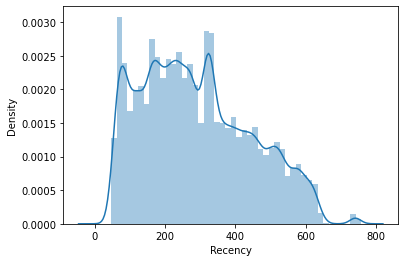

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


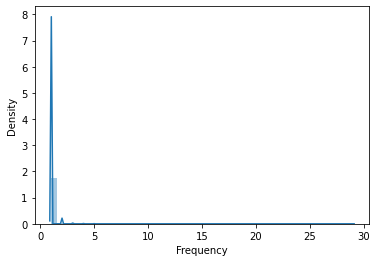

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


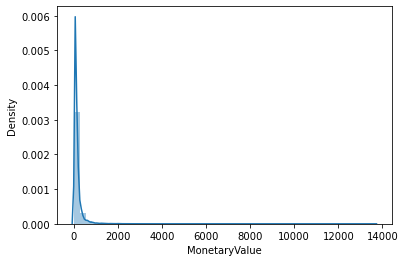

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


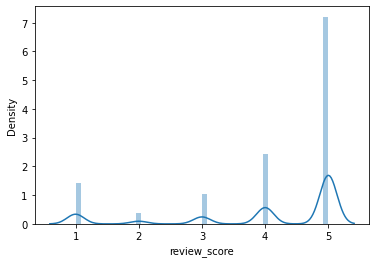

In [34]:
for col in data.columns:
    sns.distplot(data[col])
    plt.show()

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


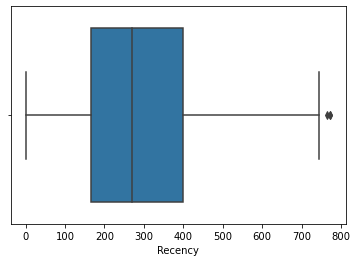

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


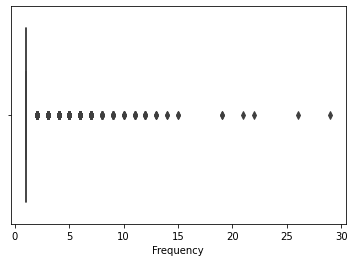

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


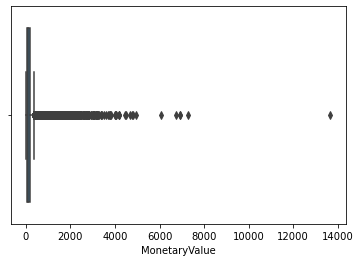

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


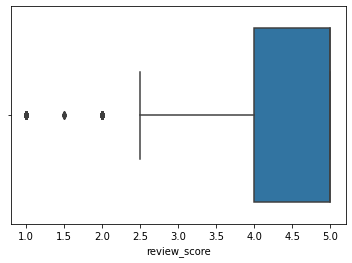

In [35]:
for col in data.columns:
    sns.boxplot(data[col])
    plt.show()